<a href="https://colab.research.google.com/github/efeecllk/investor-sentiments/blob/main/bitcoin_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install emoji

In [45]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import gensim
from sklearn.linear_model import LogisticRegression
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import string
import re
import emoji


In [46]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [47]:
# Load Bitcoin Tweet Dataset
tweets_df = pd.read_csv('/content/drive/MyDrive/NLP/Bitcoin_tweets.csv', nrows=10000)

# Load Bitcoin Price Dataset
price_df = pd.read_csv('/content/drive/MyDrive/NLP/bitcoin_2017_to_2023.csv')



In [48]:
tweets_df.head()


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [49]:
price_df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611


In [50]:
import pandas as pd

# Convert dates and times
tweets_df['user_created'] = pd.to_datetime(tweets_df['user_created'], errors='coerce')
price_df['timestamp'] = pd.to_datetime(price_df['timestamp'], errors='coerce')

# Clean invalid values and sort by time
tweets_df = tweets_df.dropna(subset=['user_created']).sort_values(by='user_created')
price_df = price_df.dropna(subset=['timestamp']).sort_values(by='timestamp')

# Match timestamps while preserving all tweets
merged_df = pd.merge_asof(
    tweets_df,
    price_df,
    left_on='user_created',
    right_on='timestamp',
    direction='backward',
    tolerance=pd.Timedelta('1d')  # Maximum 1-day difference
)

# Calculate time difference (optional)
merged_df['time_difference'] = (merged_df['user_created'] - merged_df['timestamp']).abs()

# Check for unmatched rows
missing_matches = merged_df[merged_df['timestamp'].isna()]
print(f"Number of Unmatched Tweets: {len(missing_matches)}")

# Perform forward search for unmatched tweets
merged_df_forward = pd.merge_asof(
    tweets_df,
    price_df,
    left_on='user_created',
    right_on='timestamp',
    direction='forward',
    tolerance=pd.Timedelta('1d')
)

# Combine and remove duplicates
final_merged_df = pd.concat([merged_df, merged_df_forward]).drop_duplicates(subset=['user_created'])

# Check still unmatched rows
still_missing = final_merged_df[final_merged_df['timestamp'].isna()]
print(f"Number of Still Unmatched Tweets: {len(still_missing)}")

# Display results
print("\nMatched Tweet and Price Data:")
print(final_merged_df.head())

# Remove unmatched records (rows where 'timestamp' is NaN)
final_merged_df = final_merged_df.dropna(subset=['timestamp']).reset_index(drop=True)

# Verify the final dataset
print(f"Number of Unmatched Tweets After Removal: {final_merged_df['timestamp'].isna().sum()}")
print("\nMatched Tweet and Price Data (Unmatched Removed):")
print(final_merged_df.head())


Number of Unmatched Tweets: 3969
Number of Still Unmatched Tweets: 1802

Matched Tweet and Price Data:
        user_name         user_location  \
0       Greg Kidd       Crystal Bay, NV   
1     Yaron Samid              Tel Aviv   
2  Travis Russell                   NaN   
3   ngc_3370 LION       ngc_3370 Galaxy   
4  Justin Roberti  Nonspecificville, PA   

                                    user_description        user_created  \
0  CEO GlobaliD (@myglobal_id), co-founder Hard Y... 2006-04-01 03:32:37   
1  3X dad, 3X founder, investor and community bui... 2006-12-04 19:48:28   
2  #Bitcoin | Aquaponics | Padres | https://t.co/... 2007-01-26 19:40:36   
3  “As soon as you stop wanting or dreaming somet... 2007-03-12 07:41:16   
4  Writer & podcast producer - Games, tech, finte... 2007-04-03 01:57:06   

   user_followers  user_friends  user_favourites  user_verified  \
0         12868.0           132              417          False   
1          4792.0           140             124

In [51]:
# Remove unmatched records (rows where 'timestamp' is NaN)
final_merged_df = final_merged_df.dropna(subset=['timestamp']).reset_index(drop=True)

# Verify the final dataset
print(f"Number of Unmatched Tweets After Removal: {final_merged_df['timestamp'].isna().sum()}")
print("\nMatched Tweet and Price Data (Unmatched Removed):")
print(final_merged_df.head())
merged_df = final_merged_df

Number of Unmatched Tweets After Removal: 0

Matched Tweet and Price Data (Unmatched Removed):
        user_name        user_location  \
0  Michael Arouet  Somewhere in Europe   
1       athcrypt℗              Croatia   
2     Wickhunterr                India   
3           Kayth               Europe   
4  The 1 i Am Neo      Los Angeles, CA   

                                    user_description        user_created  \
0  Independent investor, correlation deviations b... 2017-08-17 11:22:22   
1  MIT / UX & Product Designer / $BTC $ETH $DOGE ... 2017-08-18 09:29:07   
2  Pure Technical Analyst 🔥\nTrading Crypto since... 2017-08-18 14:19:50   
3                  Software Engineer. #Bitcoin only. 2017-08-18 16:40:28   
4                                     Bitcoin Trader 2017-08-18 17:36:59   

   user_followers  user_friends  user_favourites  user_verified  \
0           795.0           482             1530          False   
1           413.0           396            23026          Fal

In [52]:
merged_df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,...,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,time_difference
0,Michael Arouet,Somewhere in Europe,"Independent investor, correlation deviations b...",2017-08-17 11:22:22,795.0,482,1530,False,2021-02-09 22:34:39,"#Bitcoin unrealized losses must be recognized,...",...,4474.80,4474.80,4474.80,4474.80,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:22
1,athcrypt℗,Croatia,MIT / UX & Product Designer / $BTC $ETH $DOGE ...,2017-08-18 09:29:07,413.0,396,23026,False,2021-02-09 07:20:41,Hacked with nudes #blockfolio @blockfolio #btc...,...,4321.20,4327.25,4307.01,4307.01,0.369231,1595.893279,7.0,0.086659,374.904408,0 days 00:00:07
2,Wickhunterr,India,Pure Technical Analyst 🔥\nTrading Crypto since...,2017-08-18 14:19:50,80.0,167,1356,False,2021-02-10 00:05:25,The So called Next BTC is waking up\n\n#YFI #D...,...,4272.92,4272.92,4272.92,4272.92,0.107711,460.240486,1.0,0.107711,460.240486,0 days 00:00:50
3,Kayth,Europe,Software Engineer. #Bitcoin only.,2017-08-18 16:40:28,40.0,428,1628,False,2021-02-08 19:07:28,If you want to create a bitcoin seed with dice...,...,4266.72,4266.72,4266.72,4266.72,0.060301,257.287483,1.0,0.060301,257.287483,0 days 00:00:28
4,The 1 i Am Neo,"Los Angeles, CA",Bitcoin Trader,2017-08-18 17:36:59,142.0,95,3,False,2021-02-08 16:37:20,#Bitcoin #BTC #btcusd $btc https://t.co/lAMPlm...,...,4126.45,4126.45,4126.45,4126.45,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:59


In [53]:
merged_df = merged_df.drop('user_location', axis=1)

In [54]:
merged_df.columns

Index(['user_name', 'user_description', 'user_created', 'user_followers',
       'user_friends', 'user_favourites', 'user_verified', 'date', 'text',
       'hashtags', 'source', 'is_retweet', 'timestamp', 'open', 'high', 'low',
       'close', 'volume', 'quote_asset_volume', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
       'time_difference'],
      dtype='object')

In [55]:
merged_df.shape[0]

2415

In [56]:
def preprocess_text(text):
    text = emoji.demojize(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])
    return text



In [57]:
len(merged_df)

2415

In [58]:
merged_df['text'] = merged_df['text'].apply(preprocess_text)


In [59]:
merged_df.head()

,user_name,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,...,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,time_difference
0,Michael Arouet,"Independent investor, correlation deviations b...",2017-08-17 11:22:22,795.0,482,1530,False,2021-02-09 22:34:39,bitcoin unrealized loss must recognized unreal...,"['Bitcoin', 'BTC']",...,4474.80,4474.80,4474.80,4474.80,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:22
1,athcrypt℗,MIT / UX & Product Designer / $BTC $ETH $DOGE ...,2017-08-18 09:29:07,413.0,396,23026,False,2021-02-09 07:20:41,hacked nude blockfolio blockfolio btc bitcoin ...,"['blockfolio', 'btc', 'bitcoin', 'ethereum']",...,4321.20,4327.25,4307.01,4307.01,0.369231,1595.893279,7.0,0.086659,374.904408,0 days 00:00:07
2,Wickhunterr,Pure Technical Analyst 🔥\nTrading Crypto since...,2017-08-18 14:19:50,80.0,167,1356,False,2021-02-10 00:05:25,called next btc waking yfi defi btc binance bi...,"['YFI', 'DeFi', 'BTC', 'Binance', 'Bitcoin', '...",...,4272.92,4272.92,4272.92,4272.92,0.107711,460.240486,1.0,0.107711,460.240486,0 days 00:00:50
3,Kayth,Software Engineer. #Bitcoin only.,2017-08-18 16:40:28,40.0,428,1628,False,2021-02-08 19:07:28,want create bitcoin seed dice roll time roll d...,NaN,...,4266.72,4266.72,4266.72,4266.72,0.060301,257.287483,1.0,0.060301,257.287483,0 days 00:00:28
4,The 1 i Am Neo,Bitcoin Trader,2017-08-18 17:36:59,142.0,95,3,False,2021-02-08 16:37:20,bitcoin btc btcusd btc httpstcolamplmodt live ...,"['Bitcoin', 'BTC', 'btcusd']",...,4126.45,4126.45,4126.45,4126.45,0.000000,0.000000,0.0,0.000000,0.000000,0 days 00:00:59


In [60]:
import gensim
import pickle
import numpy as np

# Word2Vec modelini yükle
word2vec_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/NLP/word2vec_model.model')

# Logistic Regression sınıflandırıcısını yükle
with open('/content/drive/MyDrive/NLP/word2vec_logistic_model.pkl', 'rb') as file:
    sentiment_classifier = pickle.load(file)


In [61]:
def text_to_word2vec(text, model):
    words = text.split()
    # Modelin kelime vektörlerini al
    word_vectors = [model.wv[word] for word in words if word in model.wv.key_to_index]

    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # Geçerli kelime yoksa sıfır vektör döndür
    else:
        return np.mean(word_vectors, axis=0)  # Ortalama vektörü döndür


In [62]:
def sentiment_analysis(text):
    try:
        vector = text_to_word2vec(text, word2vec_model)
        sentiment = sentiment_classifier.predict([vector])[0]
        confidence = max(sentiment_classifier.predict_proba([vector])[0])
        return sentiment, round(confidence, 2)
    except Exception as e:
        print(f"Error processing text: {text}, Error: {e}")
        return 'error', 0.0


In [63]:
# Rastgele bir kelimenin vektörünü kontrol edin
test_word = 'good'  # Modelinizde olduğunu düşündüğünüz yaygın bir kelime
if test_word in word2vec_model.wv:
    print(f"{test_word} vektörü:", word2vec_model.wv[test_word])
else:
    print(f"{test_word} kelimesi Word2Vec modelinde bulunamadı.")


good vektörü: [ 2.8839207   1.3391731   7.308303    1.8964574  -2.3862646  -2.4070337
 -2.7014947  -1.3842946   0.6010865   0.47718966 -2.0427055   0.0712805
 -1.2981845   0.83583057 -1.9568009  -1.2591379  -1.8955985   4.1568966
 -1.5634154  -0.6319844  -0.16744928 -3.7785995  -2.6053498   1.0011839
  0.93321794 -0.07429277  0.43825418 -1.973161   -2.0896351  -0.33100697
 -2.007238   -0.20221233 -1.5455337   0.40533808  2.1798923  -1.7087928
  0.23598431 -1.2951624   0.58126557 -1.4197496   0.13569267 -1.1923347
  2.2944686   3.099303    2.904183    1.4573932   1.0067637   3.9175096
 -0.26833215  1.7419922   1.2856376   0.20880349  2.3304741   1.0495452
  3.0477738  -1.6131055  -0.7979749  -2.163896   -1.4567354   0.58822817
  1.6011333   1.1501036   1.5040768  -0.08322735  0.32401174  0.34224036
 -3.588203   -1.3385513  -0.512516    1.4993126   2.9119456  -0.11238984
 -1.8974228  -1.3987986   2.0573664  -3.158226   -0.19347374 -0.09233224
 -3.0921054  -7.14259     1.5415266  -1.08191

In [64]:
import gensim
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pickle


In [65]:
# Word2Vec modelini yükle
word2vec_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/NLP/word2vec_model.model')


In [66]:
# Rastgele bir kelimenin vektörünü kontrol edin
print(word2vec_model.wv['good'] if 'good' in word2vec_model.wv else "Kelime bulunamadı")


[ 2.8839207   1.3391731   7.308303    1.8964574  -2.3862646  -2.4070337
 -2.7014947  -1.3842946   0.6010865   0.47718966 -2.0427055   0.0712805
 -1.2981845   0.83583057 -1.9568009  -1.2591379  -1.8955985   4.1568966
 -1.5634154  -0.6319844  -0.16744928 -3.7785995  -2.6053498   1.0011839
  0.93321794 -0.07429277  0.43825418 -1.973161   -2.0896351  -0.33100697
 -2.007238   -0.20221233 -1.5455337   0.40533808  2.1798923  -1.7087928
  0.23598431 -1.2951624   0.58126557 -1.4197496   0.13569267 -1.1923347
  2.2944686   3.099303    2.904183    1.4573932   1.0067637   3.9175096
 -0.26833215  1.7419922   1.2856376   0.20880349  2.3304741   1.0495452
  3.0477738  -1.6131055  -0.7979749  -2.163896   -1.4567354   0.58822817
  1.6011333   1.1501036   1.5040768  -0.08322735  0.32401174  0.34224036
 -3.588203   -1.3385513  -0.512516    1.4993126   2.9119456  -0.11238984
 -1.8974228  -1.3987986   2.0573664  -3.158226   -0.19347374 -0.09233224
 -3.0921054  -7.14259     1.5415266  -1.0819113   2.4227936

In [67]:
# Boş değerleri doldur
merged_df['text'].fillna("", inplace=True)



<ipython-input-67-321c5c5a8fbc>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['text'].fillna("", inplace=True)


In [68]:
import joblib
logistic_model = joblib.load('/content/drive/MyDrive/NLP/llogistic_model.pkl')
def sentiment_analysis(text):
    vector = text_to_word2vec(text, word2vec_model)
    sentiment = logistic_model.predict([vector])[0]
    return sentiment


In [69]:

# Apply Sentiment Analysis on Tweets
merged_df['sentiment_label'] = merged_df['text'].apply(lambda x: sentiment_analysis(x))

# Display sample rows with sentiment labels
print("\nDataset with Sentiment Labels:")
print(merged_df[['text', 'sentiment_label']].head())



Dataset with Sentiment Labels:
                                                text  sentiment_label
0  bitcoin unrealized loss must recognized unreal...                2
1  hacked nude blockfolio blockfolio btc bitcoin ...                0
2  called next btc waking yfi defi btc binance bi...                1
3  want create bitcoin seed dice roll time roll d...                1
4  bitcoin btc btcusd btc httpstcolamplmodt live ...                0


In [70]:
merged_df.columns

Index(['user_name', 'user_description', 'user_created', 'user_followers',
       'user_friends', 'user_favourites', 'user_verified', 'date', 'text',
       'hashtags', 'source', 'is_retweet', 'timestamp', 'open', 'high', 'low',
       'close', 'volume', 'quote_asset_volume', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
       'time_difference', 'sentiment_label'],
      dtype='object')

In [72]:
# Cell 1: Map Numerical Labels to Text Labels

# Define the mapping dictionary
label_mapping = {0: 'Neutral', 1: 'Bullish', 2: 'Bearish'}

# Apply mapping to the 'label' column
merged_df['sentiment_label_name'] = merged_df['sentiment_label'].map(label_mapping)

# Verify if mapping was successful
print(merged_df[['sentiment_label', 'sentiment_label_name']].head())


   sentiment_label sentiment_label_name
0                2              Bearish
1                0              Neutral
2                1              Bullish
3                1              Bullish
4                0              Neutral


In [73]:
merged_df.columns

Index(['user_name', 'user_description', 'user_created', 'user_followers',
       'user_friends', 'user_favourites', 'user_verified', 'date', 'text',
       'hashtags', 'source', 'is_retweet', 'timestamp', 'open', 'high', 'low',
       'close', 'volume', 'quote_asset_volume', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
       'time_difference', 'sentiment_label', 'sentiment_label_name'],
      dtype='object')

sentiment_label_name
Bullish    1319
Neutral     579
Bearish     517
Name: count, dtype: int64


<ipython-input-75-7fb80d3e3e51>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='sentiment_label_name', palette='viridis')


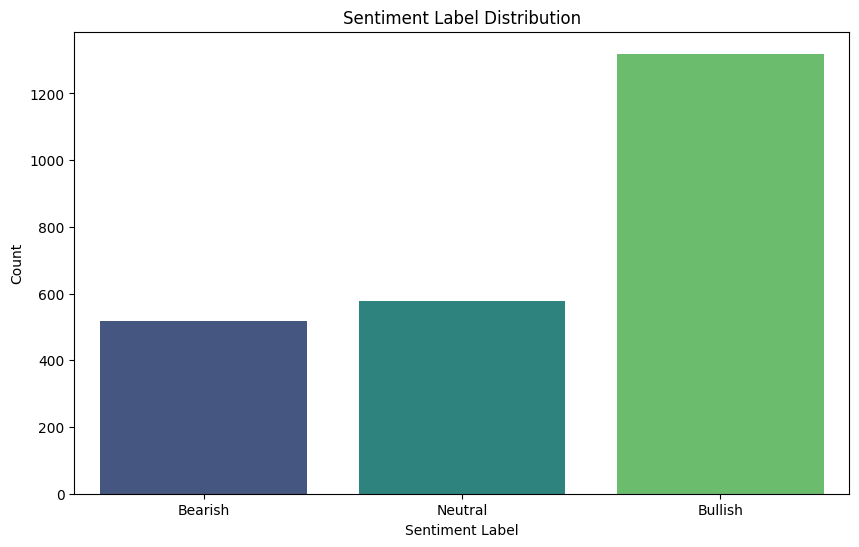

In [75]:
# Cell 3: Sentiment Label Distribution

import seaborn as sns
import matplotlib.pyplot as plt

# Display distribution
print(merged_df['sentiment_label_name'].value_counts())

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='sentiment_label_name', palette='viridis')
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()


In [78]:
# Cell 1: Calculate Daily Sentiment Counts

# Group by date and count sentiment labels
daily_sentiment = merged_df.groupby('date')['sentiment_label_name'].value_counts().unstack(fill_value=0)

# Display sample
print("\nDaily Sentiment Counts:")
print(daily_sentiment.head())



Daily Sentiment Counts:
sentiment_label_name  Bearish  Bullish  Neutral
date                                           
2021-02-08 16:32:54         0        1        0
2021-02-08 16:33:05         0        1        0
2021-02-08 16:33:17         0        0        1
2021-02-08 16:33:43         0        0        1
2021-02-08 16:34:07         0        1        0


In [80]:
# Cell 1: Convert Date to Daily Format

# Extract only the date (remove time component)
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date

# Verify the changes
print(merged_df[['date']].head())


         date
0  2021-02-09
1  2021-02-09
2  2021-02-10
3  2021-02-08
4  2021-02-08


In [81]:
# Cell 2: Calculate Total Tweets per Day

# Calculate the total number of tweets per day
daily_sentiment['total_tweets'] = daily_sentiment.sum(axis=1)

# Display sample
print("\nDaily Sentiment with Total Tweets:")
print(daily_sentiment.head())



Daily Sentiment with Total Tweets:
sentiment_label_name  Bearish  Bullish  Neutral  total_tweets
date                                                         
2021-02-08 16:32:54         0        1        0             2
2021-02-08 16:33:05         0        1        0             2
2021-02-08 16:33:17         0        0        1             2
2021-02-08 16:33:43         0        0        1             2
2021-02-08 16:34:07         0        1        0             2


In [82]:
# Cell 2: Calculate Daily Sentiment Ratios

# Group by date and count sentiment labels
daily_sentiment = merged_df.groupby('date')['sentiment_label'].value_counts().unstack(fill_value=0)

# Calculate total tweets per day
daily_sentiment['total_tweets'] = daily_sentiment.sum(axis=1)

# Calculate sentiment ratios
daily_sentiment['daily_bullish_ratio'] = daily_sentiment.get('Bullish', 0) / daily_sentiment['total_tweets']
daily_sentiment['daily_bearish_ratio'] = daily_sentiment.get('Bearish', 0) / daily_sentiment['total_tweets']
daily_sentiment['daily_neutral_ratio'] = daily_sentiment.get('Neutral', 0) / daily_sentiment['total_tweets']

# Reset index
daily_sentiment = daily_sentiment[['daily_bullish_ratio', 'daily_bearish_ratio', 'daily_neutral_ratio', 'total_tweets']].reset_index()

# Display sample
print("\nDaily Sentiment Ratios:")
print(daily_sentiment.head())



Daily Sentiment Ratios:
sentiment_label        date  daily_bullish_ratio  daily_bearish_ratio  \
0                2021-02-08                  0.0                  0.0   
1                2021-02-09                  0.0                  0.0   
2                2021-02-10                  0.0                  0.0   

sentiment_label  daily_neutral_ratio  total_tweets  
0                                0.0           533  
1                                0.0          1087  
2                                0.0           795  


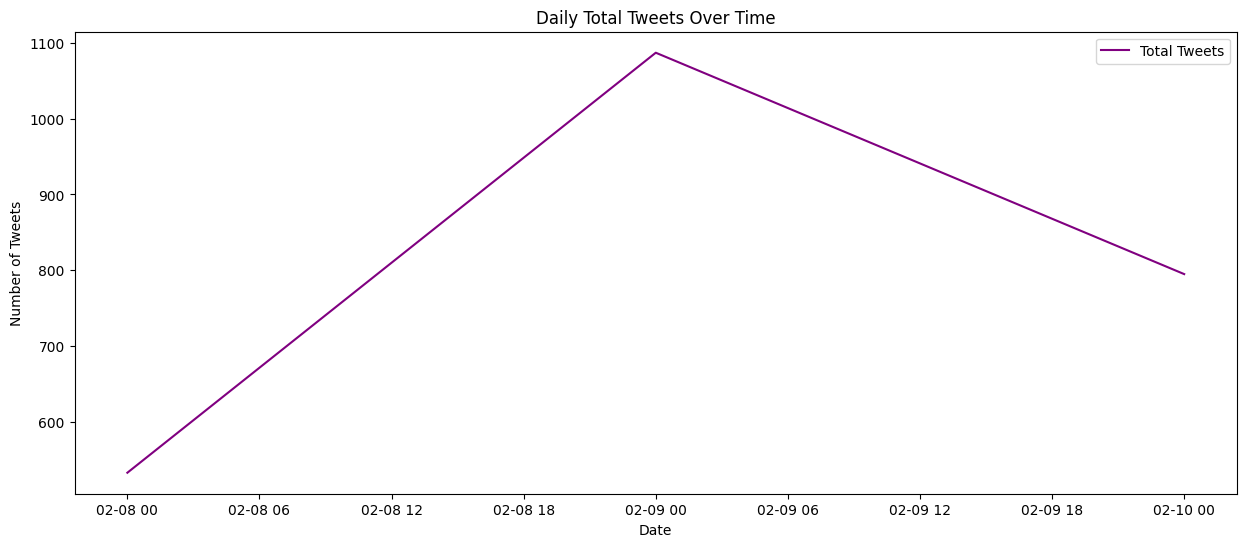

In [85]:
# Cell 5: Visualize Daily Total Tweets

plt.figure(figsize=(15, 6))
plt.plot(daily_sentiment['date'], daily_sentiment['total_tweets'], label='Total Tweets', color='purple')

plt.legend()
plt.title('Daily Total Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()


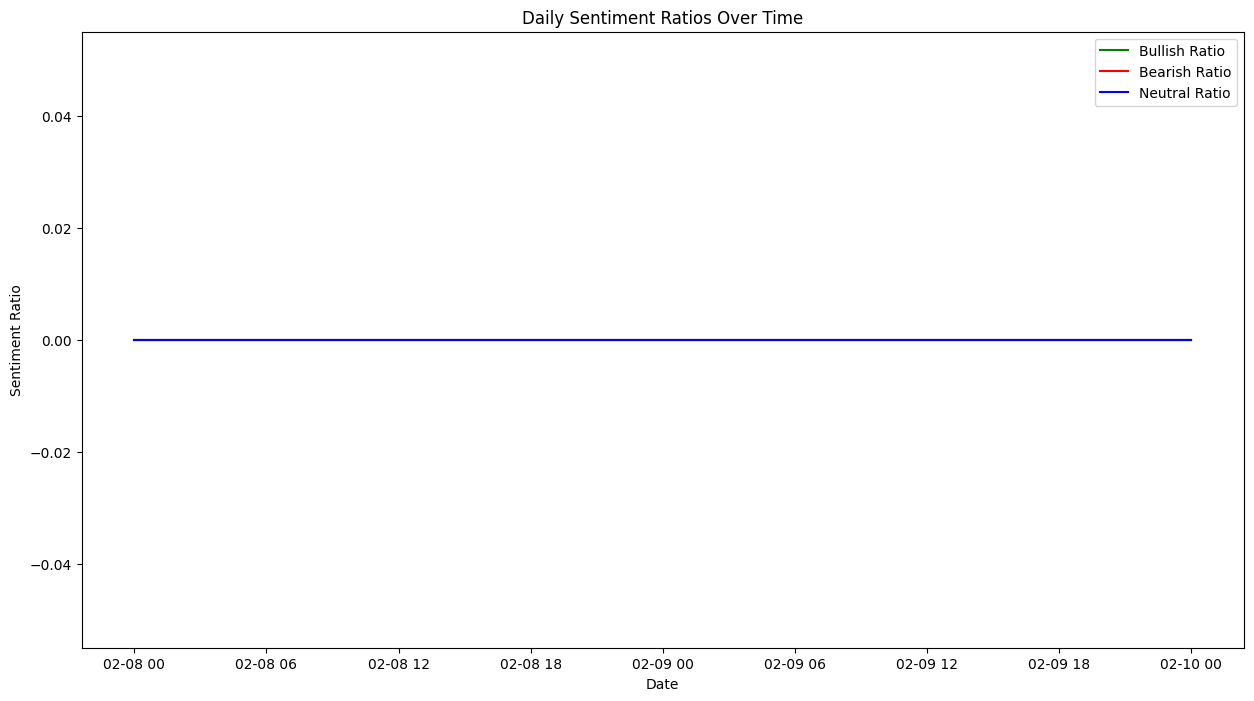

In [84]:
# Cell 4: Visualize Daily Sentiment Ratios

import matplotlib.pyplot as plt

# Plot daily sentiment ratios
plt.figure(figsize=(15, 8))
plt.plot(daily_sentiment['date'], daily_sentiment['daily_bullish_ratio'], label='Bullish Ratio', color='green')
plt.plot(daily_sentiment['date'], daily_sentiment['daily_bearish_ratio'], label='Bearish Ratio', color='red')
plt.plot(daily_sentiment['date'], daily_sentiment['daily_neutral_ratio'], label='Neutral Ratio', color='blue')

plt.legend()
plt.title('Daily Sentiment Ratios Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Ratio')
plt.show()


In [83]:
merged_df.columns

Index(['user_name', 'user_description', 'user_created', 'user_followers',
       'user_friends', 'user_favourites', 'user_verified', 'date', 'text',
       'hashtags', 'source', 'is_retweet', 'timestamp', 'open', 'high', 'low',
       'close', 'volume', 'quote_asset_volume', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
       'time_difference', 'sentiment_label', 'sentiment_label_name'],
      dtype='object')

In [ ]:
#############

In [39]:
# Cell 3: Calculate Daily Average Metrics

daily_metrics = merged_df.groupby('date').agg({
    'open': 'mean',
    'high': 'mean',
    'low': 'mean',
    'close': 'mean',
    'volume': 'mean'
}).reset_index()

# Merge with main dataset
merged_df = pd.merge(merged_df, daily_metrics, on='date', how='left')

# Display sample rows
print(merged_df[['date', 'close', 'volume']].head())


KeyError: "['close', 'volume'] not in index"